# (Pearson's)  Chi-Squared Goodness of Fit Test: 





In the standard applications of the test, the observations are classified into mutually exclusive classes.

A theory for their expected distribution is proposed, i.e the null hypothesis. Values for the expected results based that hypothesis are calculated and then compared with the observed values to compute a Chi-squared statistic:

$$ \chi^2 = \sum_{i=1}^{n} \frac{(O_i - E_i)^2}{E_i} $$

As the Chi-squared statistic is also a random variable, it displays its own distribution, seen below plotted for k degrees of freedom: 

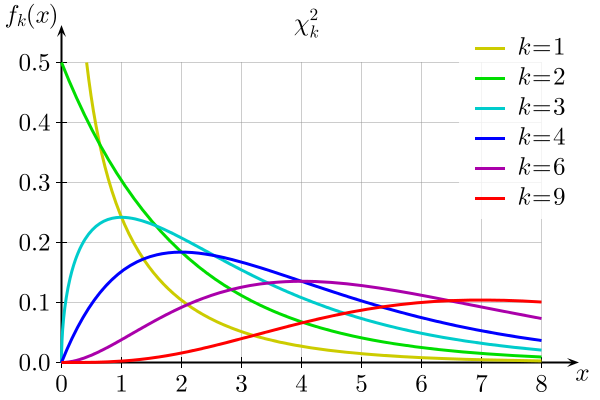

In [1]:
from IPython.display import Image
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Chi-square_pdf.svg/600px-Chi-square_pdf.svg.png'
Image(url)


From calculated chi-squared statistic and the chi-squared distribution we can calculated a p value by integrating the distribution from that point onward. The p value tells us how likely it is that we achieved that chi-square value (or greter). As a closed form integration for the cumulative distribution of the chi-squared distribution doesn't exist, the p values are often found via a lookup table. (this will be done for us using a scipy package). 

Generally we test for a p value of p= 0.05. i.e: the probability of getting this result (or a result more extreem) is less than 5%. 

If the probability of getting the expected results based on that distribution is greater than 5%, we generally do not have a statistically valid reason of discounting the null hypothesis, i.e. that our assumed distribution is valid. (Note - this is not proof that it is valid, but only that there is no statistical reason for saying that it is not)



# Demonstrating Chi-Squared With Simulated Data:


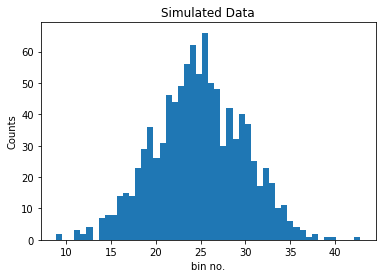

In [2]:
# first we need to generate a dataset to test
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# set a random seed so results are reproducible 
np.random.seed(123)

# Generate a normal distribution 
A = np.random.normal(25.0, 5.0, 1000)

# Plot histogram 
counts, bins, ignored = plt.hist(A, 50)
plt.xlabel("bin no.")
plt.ylabel("Counts")
plt.title('Simulated Data')
plt.show()


In [3]:
# Now we want to test to see if this fits a gausian distribution. 

# We calculate some basic stats from the dataset 
mu = np.mean(A)
var = np.var(A)
sigma = np.sqrt(var)
N = len(A)
                                       

In [4]:
# for the expected values we calculate them via the proposed normal distribution

def norm_dist(x, mu, sigma, bins):
    
    # width of our bins 
    dx = bins[1] - bins[0]
    # Need to scale the Gaussian, otherwise it is normalized and data is not
    scale = N*dx
    
    bnm = scale*1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )
    
    return bnm

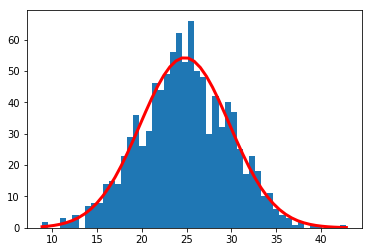

In [5]:
plt.plot(bins, norm_dist(bins, mu, sigma, bins), color='red', linewidth =3 )
plt.hist(A, 50)
plt.show()

#### For the Chi-Square statistic to be valid we need minimum 5 samples per category. We will re-bin the distribution until we achieve this:

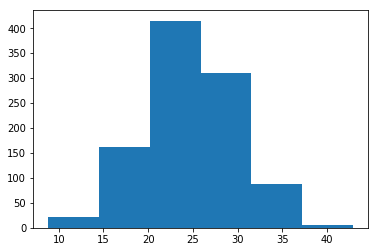

In [6]:
# chi squared doesn't work if counts are less than 5 per section 
n_bins = 50
while (min(counts) < 5):
    
    # clears the entire current figure
    plt.clf()
    counts, bins, ignored = plt.hist(A, n_bins)
    n_bins -= 1
    
plt.show()

# Finding Expectation Values 

Now that we have binned values for our normal distribution we need to check them against the expected results. 

To do this we will use the cumulative distribution for the normal distribution ( which is simply the distribution of the integral from -inf to x ). The cumulative for the normal distribution is given by: 

\begin{equation}
 F(x) = \tfrac 12 \left[1 + \operatorname{erf}\left(\frac{x-\mu}{\sigma \sqrt 2 }\right)\right] 
\end{equation}


In [7]:
from scipy import special 

def cumulant(z, mu, sigma ):
    ''' functino to calculate cumulant of norm. distribution.'''
    return 0.5*(1 + special.erf((z-mu)/(np.sqrt(2)*sigma) ) ) 
    

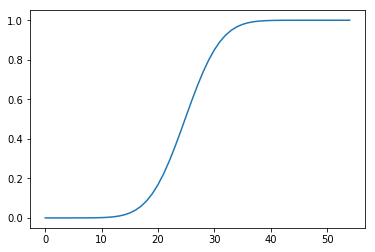

In [8]:
# plotting the cumulant distribution 

x_c = range(0,55)
plt.plot(x_c, cumulant(x_c, mu, sigma))
plt.show()


#### The cumulant looks as expected - as the entirety of the normal distribution is integrated, the probability rises to 100% that a random value will lie within that range 

#### Now we use the cumulant to calculate expected counts per bin size

In [9]:
def norm_expect(bins, mu, sigma):
    ''' function to calculate expected percentage of counts per bin from a normal distribution'''
    
    expects = [] 
    prev_cumu = cumulant(bins[0], mu, sigma)
    
    for i in range(1, len(bins)):
        
        ith_cumu = cumulant(bins[i], mu, sigma) 
        expects.append(ith_cumu - prev_cumu)
        prev_cumu = ith_cumu
                       
    return expects, prev_cumu #expects

In [10]:
expects, cumulant = norm_expect(bins, mu, sigma)

# Scale the expected values rom percentages to reflect number of counts
expects_s = [x*N for x in expects]

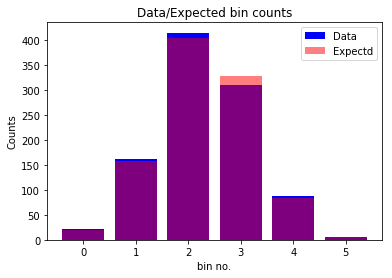

In [11]:
# Plot the counts of the data and expected results 

y = np.arange(len(expects))

plt.bar(y, counts, color='b',label='Data')
plt.bar(y, expects_s, color='r', alpha=0.5, label='Expectd')
plt.title("Data/Expected bin counts")
plt.xlabel("bin no.")
plt.ylabel("Counts")
plt.legend()
plt.show()

#### The "Chi-by-eye" test seems to check out, but the only real test to see if our data is well described by a normal distribution is to perform the chi-square test. Luckily there is a package that makes this very easy to do. 

# Perform the Chi-Square Goodness of Fit

In [12]:
from scipy import stats
stats.power_divergence(counts, f_exp=expects_s, ddof=0,  lambda_='pearson')

Power_divergenceResult(statistic=1.9581748919961099, pvalue=0.85490155535047463)

The P value is very high. This means that there is an ~85% chance of getting a value more extreem than this. 
This is much higher than the 5% threshold for rejecting the null hypothesis, therefore we have no good reason to reject that this data is normally distributed